# DeepBind Analysis

## Imports

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Maximum, Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

from keras import backend as K

Using TensorFlow backend.


In [38]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline

from sklearn import model_selection

import seaborn as sns
from matplotlib import pyplot as plt

In [18]:
if not os.path.isdir('/home/jtao/analysis/deepbind_analysis'):
    os.mkdir('/home/jtao/analysis/deepbind_analysis')
os.chdir('/home/jtao/analysis/deepbind_analysis')

In [2]:
batch_size = 128
num_classes = 10
epochs = 12

## Copy Fasta File and Background

In [779]:
! cp /home/jtao/analysis/ap1_fdr_analysis/idr_peak_files/c57bl6_atf3_veh_idr_peaks.tsv ./

In [885]:
target_peak_size = 200
current_peak_frame = pd.read_csv('./c57bl6_atf3_veh_idr_peaks.tsv', sep='\t' )
peakCenters = (current_peak_frame['start'] + current_peak_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
current_peak_frame['start'] = new_starts
current_peak_frame['end'] = new_ends
current_peak_frame.to_csv('./c57bl6_atf3_veh_resized_peaks.tsv', sep='\t', index=False)

In [886]:
! pos2bed.pl ./c57bl6_atf3_veh_resized_peaks.tsv > ./c57bl6_atf3_veh_idr_peaks.bed


	Converted 23160 peaks total



In [887]:
! /home/jtao/code/tba/model_training/extract_sequences.py ./c57bl6_atf3_veh_idr_peaks.bed mm10 ./c57bl6_atf3_veh_idr_peaks.fasta

reading genome mm10


In [888]:
! /home/jtao/code/tba/model_training/generate_background_coordinates.py ./c57bl6_atf3_veh_idr_peaks.bed ./ #-filterChromosomes chrY

filtering out: chrM chrY
reading genome mm10
done reading genome
0 0
target GC: 0.3800343317878802 background GC: 0.3769579678174266 target length: 201 numTargetPositions 2316 backgroundPositions 2316
0 0
target GC: 0.4188299824646237 background GC: 0.4160061731560868 target length: 201 numTargetPositions 2316 backgroundPositions 2316
0 0
target GC: 0.4404232205932298 background GC: 0.4392174968791277 target length: 201 numTargetPositions 2316 backgroundPositions 2316
0 0
target GC: 0.4578405042088684 background GC: 0.45465218228076587 target length: 201 numTargetPositions 2315 backgroundPositions 2315
0 0
target GC: 0.4735631833138448 background GC: 0.4686653978571801 target length: 201 numTargetPositions 2315 backgroundPositions 2315
0 0
target GC: 0.4895179632038591 background GC: 0.48386331073701777 target length: 201 numTargetPositions 2315 backgroundPositions 2315
0 0
target GC: 0.5072371388764302 background GC: 0.5009644376963623 target length: 201 numTargetPositions 2315 backgr

## Sequential API Implementation

### Set up Training and Test Data

In [986]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''

    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0.25,0.25,0.25,0.25]}

    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    sequence_array_list = np.array(sequence_array_list)
    return sequence_array_list

In [434]:
sequences = []
positive_seqRecords = list(SeqIO.parse('./c57bl6_atf3_veh_idr_peaks.fasta', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background.fasta', 'fasta'))

fasta_seq = [str(x.seq)[:200] for x in positive_seqRecords] + [str(x.seq)[:200] for x in negative_seqRecords]

In [435]:

labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

In [436]:
sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

In [437]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, labels, test_size=0.2)

In [438]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Define Model

In [469]:
num_classes = 2
model = Sequential()
model.add(Conv1D(filters=16, 
                 kernel_size=24,
                 activation='relu',
                 input_shape=(200,4)))
model.add(MaxPooling1D(pool_size=176))
model.add(Dense(32, activation='relu'))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### Train Model

In [470]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 37044 samples, validate on 9262 samples
Epoch 1/10
37044/37044 [==============================] - 4s - loss: 0.6815 - acc: 0.5662 - val_loss: 0.6453 - val_acc: 0.7153
Epoch 2/10
37044/37044 [==============================] - 4s - loss: 0.5805 - acc: 0.7140 - val_loss: 0.5224 - val_acc: 0.7414
Epoch 3/10
37044/37044 [==============================] - 4s - loss: 0.4624 - acc: 0.7890 - val_loss: 0.4297 - val_acc: 0.8031
Epoch 4/10
37044/37044 [==============================] - 4s - loss: 0.4144 - acc: 0.8166 - val_loss: 0.3978 - val_acc: 0.8224
Epoch 5/10
37044/37044 [==============================] - 4s - loss: 0.3921 - acc: 0.8291 - val_loss: 0.3856 - val_acc: 0.8302
Epoch 6/10
37044/37044 [==============================] - 4s - loss: 0.3716 - acc: 0.8401 - val_loss: 0.3697 - val_acc: 0.8393
Epoch 7/10
37044/37044 [==============================] - 4s - loss: 0.3581 - acc: 0.8489 - val_loss: 0.3625 - val_acc: 0.8417
Epoch 8/10
37044/37044 [==============================] - 4s -

## Functional API Implementation

In [592]:
num_classes = 2
input_fwd = Input(shape=(200,4), name='input_fwd')

shared_motif_convolution = Conv1D(filters=16, 
     kernel_size=24,
     activation='relu',
     input_shape=(200,4))

motif_scores_fwd = shared_motif_convolution(input_fwd)

max_seq_scores = MaxPooling1D(pool_size=176)(motif_scores_fwd)

dense_out = Dense(32, activation='relu')(max_seq_scores)

drop_out = Dropout(0.25)(dense_out)

flattened = Flatten()(drop_out)

predictions = Dense(num_classes, activation = 'softmax')(flattened)

model = Model(inputs=input_fwd, outputs=predictions)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [587]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 37044 samples, validate on 9262 samples
Epoch 1/10
37044/37044 [==============================] - 4s - loss: 0.6871 - acc: 0.5475 - val_loss: 0.6674 - val_acc: 0.6139
Epoch 2/10
37044/37044 [==============================] - 4s - loss: 0.5927 - acc: 0.7054 - val_loss: 0.5126 - val_acc: 0.7590
Epoch 3/10
37044/37044 [==============================] - 4s - loss: 0.4724 - acc: 0.7813 - val_loss: 0.4604 - val_acc: 0.7817
Epoch 4/10
37044/37044 [==============================] - 4s - loss: 0.4247 - acc: 0.8120 - val_loss: 0.4049 - val_acc: 0.8217
Epoch 5/10
37044/37044 [==============================] - 4s - loss: 0.3982 - acc: 0.8269 - val_loss: 0.3893 - val_acc: 0.8301
Epoch 6/10
37044/37044 [==============================] - 4s - loss: 0.3817 - acc: 0.8354 - val_loss: 0.3806 - val_acc: 0.8342
Epoch 7/10
37044/37044 [==============================] - 4s - loss: 0.3717 - acc: 0.8428 - val_loss: 0.3902 - val_acc: 0.8304
Epoch 8/10
37044/37044 [==============================] - 4s -

## Define Model with Reverse Complement

In [890]:
sequences = []
positive_seqRecords = list(SeqIO.parse('./c57bl6_atf3_veh_idr_peaks.fasta', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background.fasta', 'fasta'))
fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

In [891]:
fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
    [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

In [892]:
sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

In [893]:
sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)
sequence_rc_arrays = np.array(sequence_rc_arrays)

In [1097]:
labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

In [1099]:
x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

In [1100]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [1219]:
convolution_initializer = keras.initializers.glorot_normal()
dense_initializer = keras.initializers.glorot_normal()

In [1211]:
convolution_initializer = keras.initializers.RandomNormal(mean=0,stddev=1e-2 ) # [1e-7, 1e-3]
dense_initializer = keras.initializers.RandomNormal(mean=0, stddev=1e-1) # [1e-5, 1e-2]\

In [1220]:
num_classes = 2
motif_size = 24
num_motifs = 16

In [1221]:
# define input tensors
input_fwd = Input(shape=(200,4), name='input_fwd')
input_rev = Input(shape=(200,4), name='input_rev')

# fwd and reverse sequence should share convolution layer
shared_motif_convolution = Conv1D(filters=num_motifs, 
     kernel_size=motif_size,
     activation='relu',
     input_shape=(200,4),
     name = 'shared_motif_convolution',
     kernel_initializer = convolution_initializer,
     kernel_regularizer = keras.regularizers.l1(1e-5)
    )

# perform convolution on sequences and their reverse complement using the same convolution layer
motif_scores_fwd = shared_motif_convolution(input_fwd)
motif_scores_rev = shared_motif_convolution(input_rev)

# take the best score from fwd or rev orientations for each motif
max_strand_scores = Maximum()([motif_scores_fwd, motif_scores_rev])

# take the highest score for each sequence
max_seq_scores = MaxPooling1D(pool_size=200 - motif_size)(max_strand_scores)

# fully connected layer
dense_out = Dense(32, activation='relu', 
                  kernel_initializer= dense_initializer,
                  kernel_regularizer=keras.regularizers.l1(1e-5)
                 )(max_seq_scores)

# drop out
drop_out = Dropout(0.5)(dense_out)

# make prediction
flattened = Flatten()(drop_out)
predictions = Dense(num_classes,
                    activation = 'softmax', 
                    kernel_initializer=dense_initializer,
                    kernel_regularizer = keras.regularizers.l1(1e-5)
                   )(flattened)

# define and compile model
model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.sgd(lr = 0.05,
# #                                              momentum=0.99, nesterov=True
#                                             ),
#               metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [1223]:
model.fit([x_train, x_rc_train], y_train,
          batch_size=64,
          epochs=20,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 37044 samples, validate on 9262 samples
Epoch 1/20
37044/37044 [==============================] - 7s - loss: 0.4781 - acc: 0.7809 - val_loss: 0.4057 - val_acc: 0.8201
Epoch 2/20
37044/37044 [==============================] - 7s - loss: 0.3962 - acc: 0.8317 - val_loss: 0.3935 - val_acc: 0.8227
Epoch 3/20
37044/37044 [==============================] - 7s - loss: 0.3612 - acc: 0.8514 - val_loss: 0.3668 - val_acc: 0.8432
Epoch 4/20
37044/37044 [==============================] - 7s - loss: 0.3312 - acc: 0.8651 - val_loss: 0.3243 - val_acc: 0.8643
Epoch 5/20
37044/37044 [==============================] - 7s - loss: 0.3149 - acc: 0.8741 - val_loss: 0.3066 - val_acc: 0.8732
Epoch 6/20
37044/37044 [==============================] - 7s - loss: 0.3059 - acc: 0.8795 - val_loss: 0.3070 - val_acc: 0.8707
Epoch 7/20
37044/37044 [==============================] - 7s - loss: 0.2989 - acc: 0.8805 - val_loss: 0.3020 - val_acc: 0.8757
Epoch 8/20
37044/37044 [==============================] - 7s -

In [1224]:
weights = model.get_layer('shared_motif_convolution').get_weights()

In [1230]:
motifs = weights[0]

In [1121]:
index_seq_dict = dict(zip(range(4), ['A','C', 'G', 'T']))

GTACATACCTGGGGAGTCCAGATC


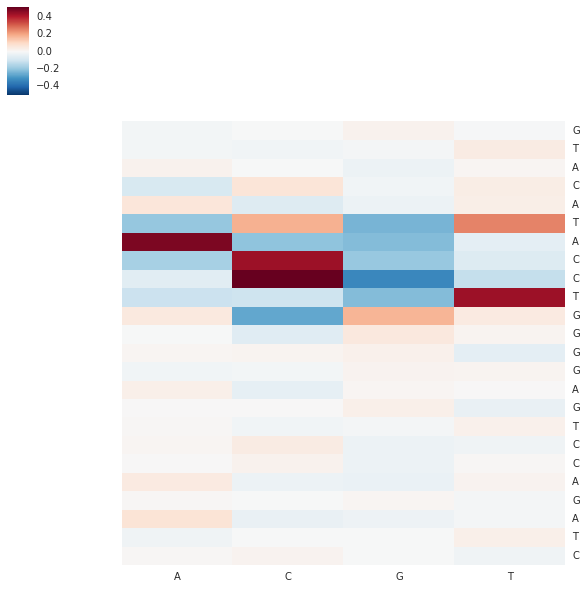

AAAGGCGATTACGTCATCGTGCGG


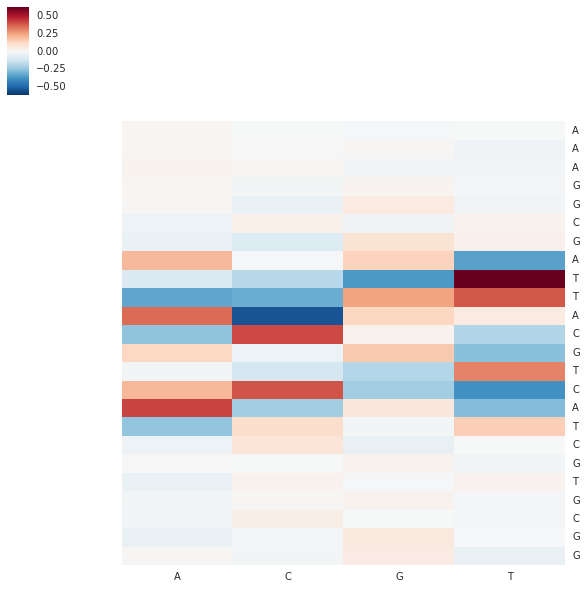

TAAATTCTTTTCAATTAGATTGGT


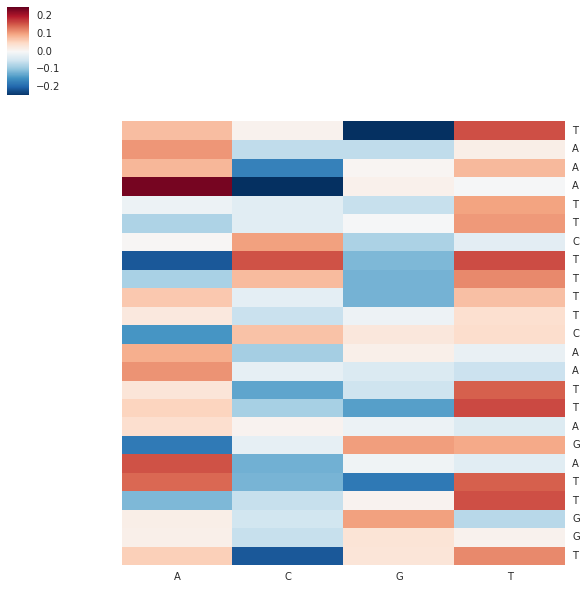

AAGCGGAAGTGAGACCGGGGTGAT


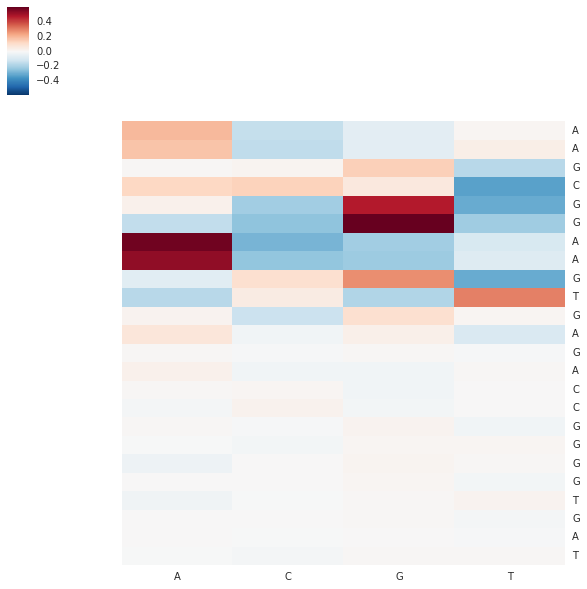

GTCGTACCATTTACTGACCGACCA


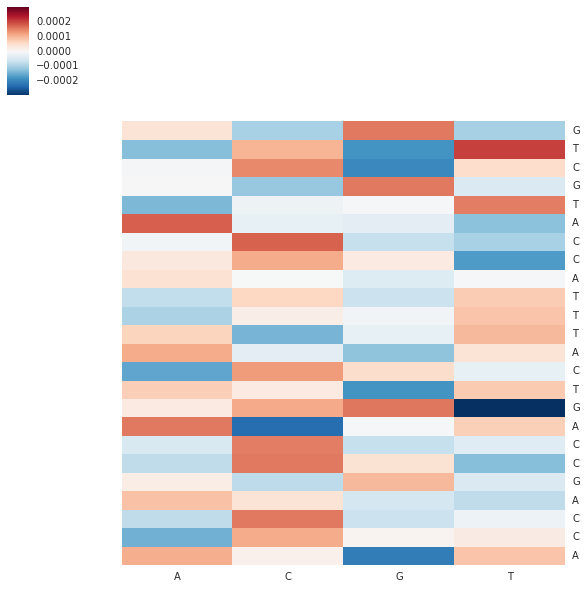

GCATCCAGAGGTATATAGAACGAG


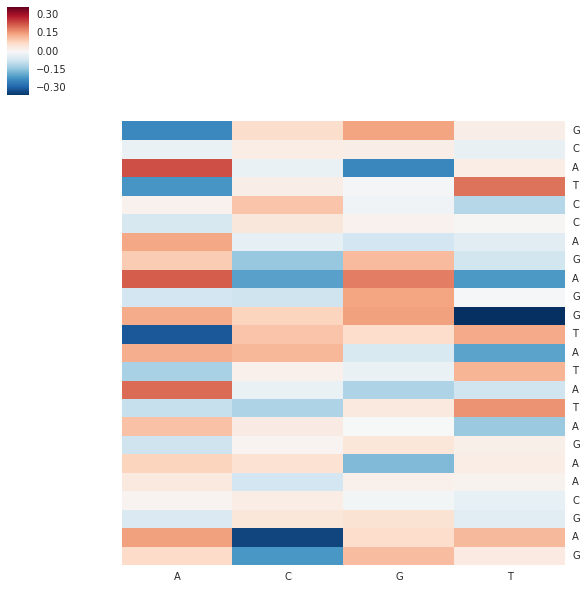

CTTTATACCTCAAACTGTCCATAA


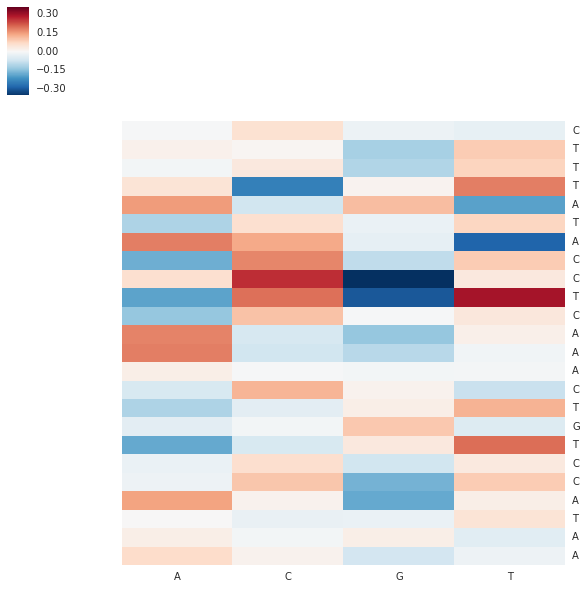

CTAGTCACGCGCGCGCGGCGGATG


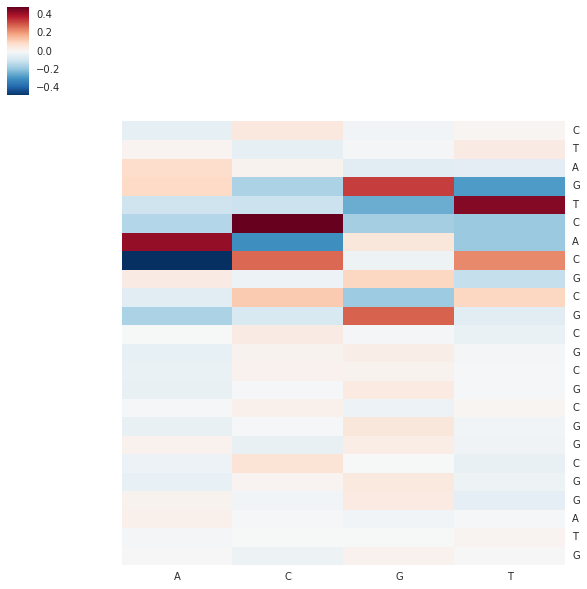

TAGCCTCGAACAAGGATGAGTCAT


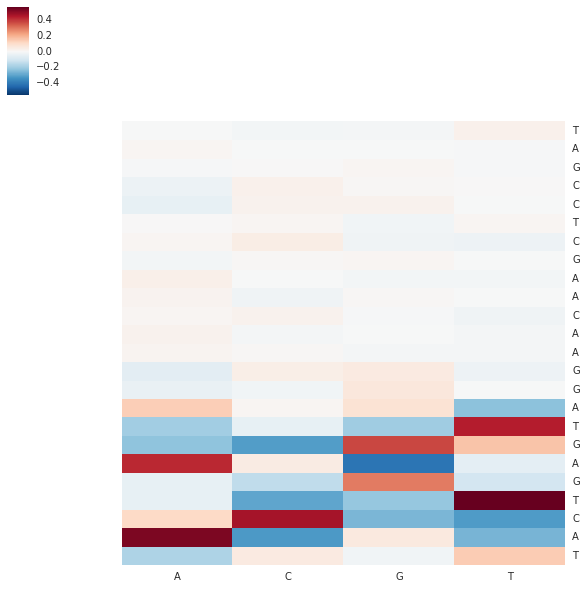

AGATTAATTCTCTAGGATATTCTA


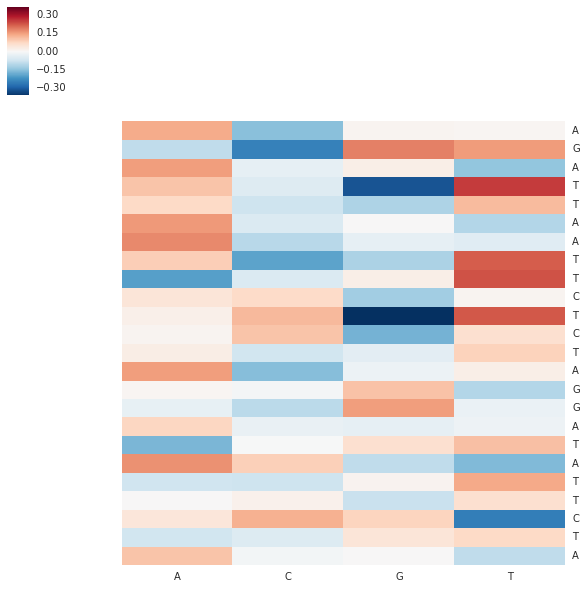

AATATCGGGGACCCCTATTTAAGG


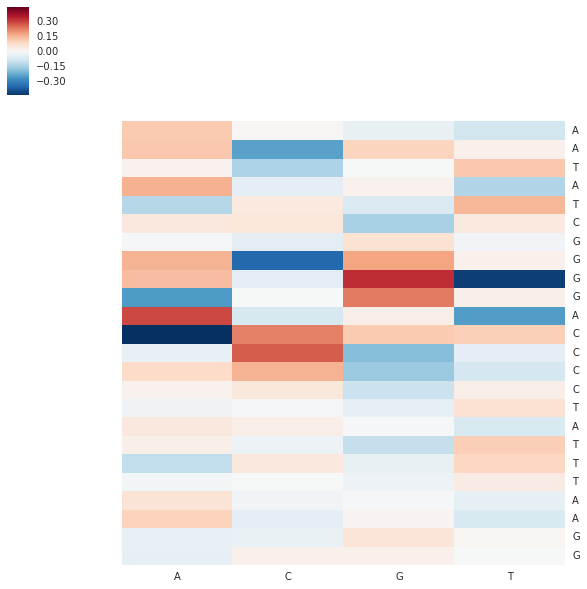

CCGATTACGCAATACGGGGCGTCC


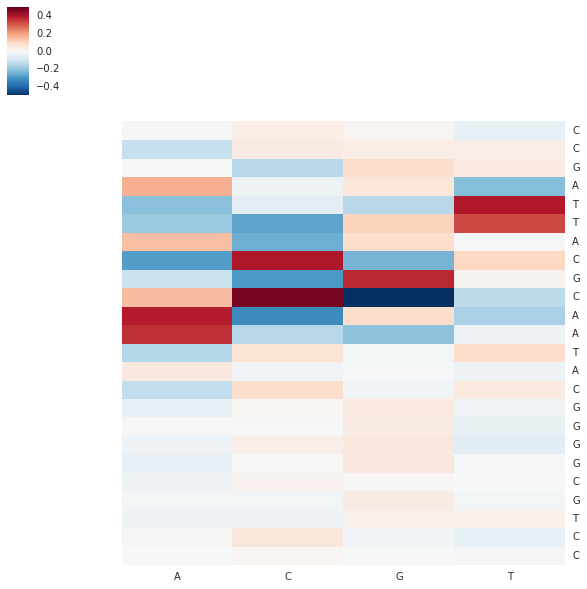

ATATATGGGATGGATGCACCTAAT


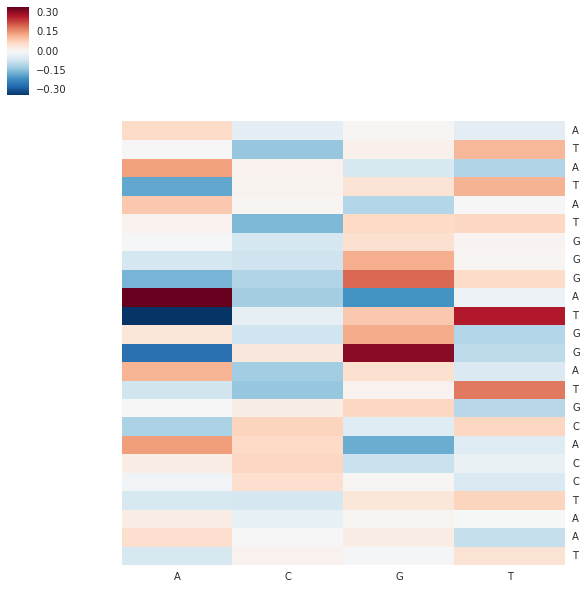

CATATTGGAGCTGGGTATGCTCCT


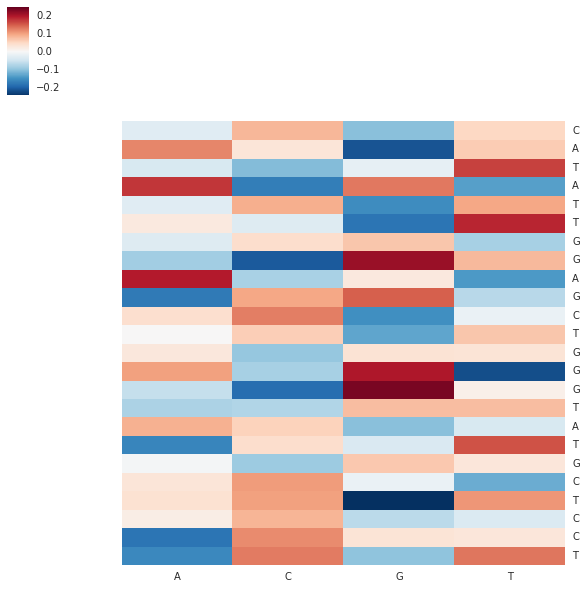

ATAGTTGTAGACCACCTGTACAAG


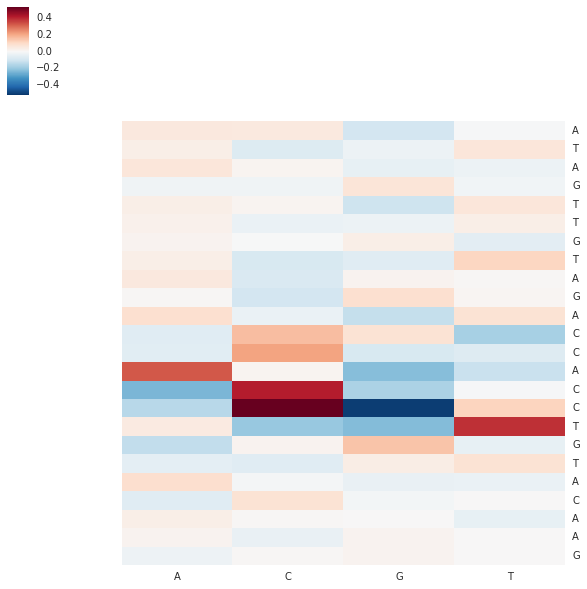

GGATCCAAGGACCTATAGGGGTGC


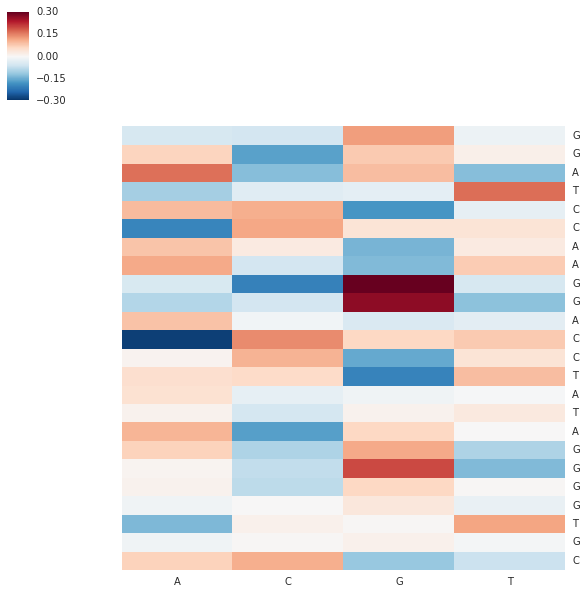

GTACATACCTGGGGAGTCCAGATC
AAAGGCGATTACGTCATCGTGCGG
TAAATTCTTTTCAATTAGATTGGT
AAGCGGAAGTGAGACCGGGGTGAT
GTCGTACCATTTACTGACCGACCA
GCATCCAGAGGTATATAGAACGAG
CTTTATACCTCAAACTGTCCATAA
CTAGTCACGCGCGCGCGGCGGATG
TAGCCTCGAACAAGGATGAGTCAT
AGATTAATTCTCTAGGATATTCTA
AATATCGGGGACCCCTATTTAAGG
CCGATTACGCAATACGGGGCGTCC
ATATATGGGATGGATGCACCTAAT
CATATTGGAGCTGGGTATGCTCCT
ATAGTTGTAGACCACCTGTACAAG
GGATCCAAGGACCTATAGGGGTGC


In [1234]:
seq_list = []
for i in range(num_motifs):
    motif = motifs[:,:,i]
    normed_motif = np.array([row - np.mean(row) for row in motif])
    
    sequence = ''.join([index_seq_dict[np.argmax(x)] for x in motif])
    seq_list.append(sequence)
    normed_motif = pd.DataFrame(normed_motif, index = list(sequence), columns=['A','C','G','T'])
    print(sequence)
    cg = sns.clustermap(normed_motif,
#                   z_score=0,
                  row_cluster = False,
                  col_cluster=False,
#                   vmin=-0.2,
#                   vmax=0.2
                  )
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.show()
for s in seq_list:
    print(s)

## Create Logos

In [1235]:
positive_fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords]
positive_fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords]
positive_sequence_arrays = convert_sequences_to_array(positive_fasta_seq)
positive_sequence_rc_arrays = convert_sequences_to_array(positive_fasta_rc_seq)


In [1236]:
motifs = weights[0]
biases = weights[1]
alphabet = Bio.Seq.IUPAC.Alphabet.IUPAC.IUPACUnambiguousDNA()



In [ ]:
bio_motifs_list = []
for i,b in zip(range(len(motifs)), biases):
    current_motif = motifs[:,:,i]
    current_size = current_motif.shape[0]
    # loop through sequences
    sequences = []
    scores = []
    counter = 0
    for fwd_seq, rev_seq in zip(positive_sequence_arrays, positive_sequence_rc_arrays):
        max_score = -1
        max_seq = None
        for i in range(fwd_seq.shape[0] - current_size + 1):
            sub_seq = fwd_seq[i:i+current_size]
            score = (current_motif*sub_seq).sum() + b
            if score > max_score:
                max_score = score
                max_seq = sub_seq
            scores.append(score)
        for i in range(rev_seq.shape[0] - current_size + 1):
            sub_seq = rev_seq[i:i+current_size]
            score = (current_motif*sub_seq).sum() + b
            if score > max_score:
                max_score = score
                max_seq = sub_seq
            scores.append(score)
        if max_score > 0:
            sequences.append(max_seq)
        counter += 1
        if counter % 10000 == 0:
            print(counter)
    if len(sequences) > 0:
        counts = np.array(sequences).sum(axis=0)
        counts_dict = {x[0]:x[1] for x in zip(list('ACGT'), counts.T)}
        bio_motif = Bio.motifs.Motif(alphabet = alphabet, counts = counts_dict)
        bio_motifs_list.append(bio_motif)

In [ ]:
for i in range(len(bio_motifs_list)):
    bm = bio_motifs_list[i]
    bm.weblogo('motif_' +str(i) + '.pdf', format='PDF')